In [0]:
!pip install kaggle
!apt-get install unzip


Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [0]:
#import dependancies
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.layers as KL
from skimage import io
from skimage.util import random_noise
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import keras
from keras.layers import Input
from keras.models import Model
from keras import regularizers
import keras.backend as K
import time
import math


Using TensorFlow backend.


In [0]:
#upload kaggle credentials
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"armughan","key":"b9643f15eb0f202a7209007129e357eb"}'}

In [0]:
!ls

kaggle.json  sample_data


In [0]:
#file configuration
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
#downloading data
!kaggle datasets download -d jessicali9530/lfw-dataset

 90% 100M/111M [00:02<00:00, 25.8MB/s] 
100% 111M/111M [00:02<00:00, 41.3MB/s]


In [0]:
!ls

kaggle.json  lfw-dataset.zip  sample_data


In [0]:
# unzip file
!mkdir lfw_data
!unzip lfw-dataset.zip -d lfw_data


Archive:  lfw-dataset.zip
  inflating: lfw_data/peopleDevTest.csv  
  inflating: lfw_data/matchpairsDevTrain.csv  
  inflating: lfw_data/mismatchpairsDevTest.csv  
  inflating: lfw_data/matchpairsDevTest.csv  
  inflating: lfw_data/lfw_readme.csv  
  inflating: lfw_data/pairs.csv      
  inflating: lfw_data/mismatchpairsDevTrain.csv  
  inflating: lfw_data/lfw_allnames.csv  
  inflating: lfw_data/peopleDevTrain.csv  
  inflating: lfw_data/people.csv     
  inflating: lfw_data/lfw-deepfunneled.zip  


In [0]:
#unzipping images

!unzip ./lfw_data/lfw-deepfunneled.zip -d lfw_data/

Archive:  ./lfw_data/lfw-deepfunneled.zip
   creating: lfw_data/lfw-deepfunneled/
   creating: lfw_data/lfw-deepfunneled/German_Khan/
  inflating: lfw_data/lfw-deepfunneled/German_Khan/German_Khan_0001.jpg  
   creating: lfw_data/__MACOSX/
   creating: lfw_data/__MACOSX/lfw-deepfunneled/
   creating: lfw_data/__MACOSX/lfw-deepfunneled/German_Khan/
  inflating: lfw_data/__MACOSX/lfw-deepfunneled/German_Khan/._German_Khan_0001.jpg  
  inflating: lfw_data/__MACOSX/lfw-deepfunneled/._German_Khan  
   creating: lfw_data/lfw-deepfunneled/Stefano_Gabbana/
  inflating: lfw_data/lfw-deepfunneled/Stefano_Gabbana/Stefano_Gabbana_0001.jpg  
   creating: lfw_data/__MACOSX/lfw-deepfunneled/Stefano_Gabbana/
  inflating: lfw_data/__MACOSX/lfw-deepfunneled/Stefano_Gabbana/._Stefano_Gabbana_0001.jpg  
  inflating: lfw_data/__MACOSX/lfw-deepfunneled/._Stefano_Gabbana  
   creating: lfw_data/lfw-deepfunneled/Dragan_Covic/
  inflating: lfw_data/lfw-deepfunneled/Dragan_Covic/Dragan_Covic_0001.jpg  
   creat

In [0]:
!ls
print("\n")
!ls ./lfw_data/
print("\n")

!ls ./lfw_data/lfw-deepfunneled/



kaggle.json  lfw_data  lfw-dataset.zip	sample_data


lfw_allnames.csv      matchpairsDevTest.csv	 people.csv
lfw-deepfunneled      matchpairsDevTrain.csv	 peopleDevTest.csv
lfw-deepfunneled.zip  mismatchpairsDevTest.csv	 peopleDevTrain.csv
lfw_readme.csv	      mismatchpairsDevTrain.csv
__MACOSX	      pairs.csv


Aaron_Eckhart			 Joshua_Harapko
Aaron_Guiel			 Joshua_Perper
Aaron_Patterson			 Joxel_Garcia
Aaron_Peirsol			 Joy_Bryant
Aaron_Pena			 Joy_Lee_Sadler
Aaron_Sorkin			 JP_Suarez
Aaron_Tippin			 JT_Snow
Abba_Eban			 Juan_Antonio_Samaranch
Abbas_Kiarostami		 Juan_Carlos
Abdel_Aziz_Al-Hakim		 Juan_Carlos_Ferrero
Abdel_Madi_Shabneh		 Juan_Carlos_Morales
Abdel_Nasser_Assidi		 Juan_Carlos_Ortega
Abdoulaye_Wade			 Juanes
Abdulaziz_Kamilov		 Juan_Fernandez
Abdullah			 Juan_Francisco_Palencia
Abdullah_Ahmad_Badawi		 Juan_Ignacio_Chela
Abdullah_al-Attiyah		 Juan_Jose_Lucas
Abdullah_Gul			 Juan_Manuel_Marquez
Abdullah_Nasseef		 Juan_Pablo_Montoya
Abdullatif_Sener		 Juan_Roman_Carrasco
Abdul

## Data Loading,Augmentation,Spliting and preprocessing

In [0]:
class Data:
  
  def __init__(self,data_dir):
    self.data_dir=data_dir
    self.pos_thresh=6   #positive/anchor images will include people that have more than this number of photos 
    self.neg_thresh=3   #negative images will include people that have less than this number of photos 
    self.train_fr=0.90
    self.train_images_augmentation=False#True
    self.flip_images=True
    self.add_noise=True
    
  def filter_people_on_thresh(self,all_people,low_num_images_thresh=8,high_num_images_thresh=100):
    mask=(all_people['images']>=low_num_images_thresh)
    filtered_people=all_people[mask]
    
    mask= (filtered_people['images']<=high_num_images_thresh)
    filtered_people=filtered_people[mask]
    print("logging:==> num people with images >=  {}  and <= {} is {}".format(low_num_images_thresh,high_num_images_thresh,filtered_people.shape[0]))
    return filtered_people
  
  def augment_images(self,images_list):
    #images_list is a list of images for a person
    num_images=len(images_list)
    images_list=[images_list[i] for i in range(num_images)]
    for i in range(num_images):
      if self.flip_images:
        fl_image=images_list[i][:,::-1,:]
        images_list.append(fl_image)
      if self.add_noise:
        n_image=(random_noise(images_list[i], mode='gaussian',clip=True )*255).astype(np.uint8)
        images_list.append(n_image)
        
    return images_list
  
  def load_images(self,people_names,augmentation=False,images_dir="./"): 
    #people_names is a series that contains the names of the peole whose images we want to use
    # images dir is the dircetory where folders of images of diif people are present
    all_images=[]
    for index,person in enumerate(people_names):
        folder_path=os.path.join(images_dir,person)
        img_paths=[os.path.join(folder_path,img) for img in os.listdir(folder_path)]
        person_images=io.imread_collection(img_paths)
        if augmentation:
          person_images=self.augment_images(person_images)
          
        all_images.append(person_images)
    return all_images
  
  
    
  
  def load_data(self):
    all_names=pd.read_csv(os.path.join(self.data_dir,"lfw_allnames.csv"))# pd dataframe contain person name and num_images for that peson
    #filtering people for positive examples
    self.pos_people=self.filter_people_on_thresh(all_names,self.pos_thresh)
    self.pos_people=shuffle(self.pos_people)
    #filtering people for negative examples
    self.neg_people=self.filter_people_on_thresh(all_names,1,self.neg_thresh)
    self.neg_people=shuffle(self.neg_people)
    
    images_dir=os.path.join(self.data_dir,"lfw-deepfunneled/")
    print ("image directory={}".format(images_dir))
    self.pos_imgs=self.load_images(self.pos_people['name'],augmentation=self.train_images_augmentation,images_dir=images_dir)
    self.neg_imgs=self.load_images(self.neg_people['name'],augmentation=False,images_dir=images_dir)
    
    self.test_people=self.filter_people_on_thresh(all_names,self.neg_thresh,self.pos_thresh)
        
  def load_test_data(self):
    names=self.test_people['name']
    images_dir=os.path.join(self.data_dir,"lfw-deepfunneled/")
    images=self.load_images(names,augmentation=False,images_dir=images_dir)
    return names,images
  
  def train_val_split(self): #splits into train and val set
    train_fr=self.train_fr
    pos_len=len(self.pos_imgs)
    neg_len=len(self.neg_imgs)
    
    train_pos_len=int(train_fr*pos_len)
    val_pos_len=pos_len-train_pos_len
    
    train_neg_len=int(train_fr*neg_len)
    val_neg_len=neg_len-train_neg_len
    
    #splitting into train and validation
    self.train_pos_imgs=self.pos_imgs[:train_pos_len]
    self.val_pos_imgs=self.pos_imgs[train_pos_len:]
    
    self.train_neg_imgs=self.neg_imgs[:train_neg_len]
    self.val_neg_imgs=self.neg_imgs[train_neg_len:]
    
  def visualize(self):
    print ("===>Visualizing Data<===\n")
    print ("num of train pos images={}".format(len(self.train_pos_imgs)))
    print ("num of train neg images={}".format(len(self.train_neg_imgs)))
    print ("num of val pos images={}".format(len(self.val_pos_imgs)))
    print ("num of val neg images={}".format(len(self.val_neg_imgs)))
    
    print ("drawing images\n")
    
#     print ("\tTrain pos")
    fig,axis=plt.subplots(1,self.pos_thresh,figsize=(9,3))
    fig.suptitle("train pos images")
    fig.tight_layout()
    for i in np.arange(self.pos_thresh):
      axis[i].imshow(self.train_pos_imgs[1][i])
#       b=axis[0,i]
      
      
#     print ("\tTrain neg")
    fig,axis=plt.subplots(1,figsize=(3,3))
    fig.suptitle("train neg images")
    fig.tight_layout()
    axis.imshow(self.train_neg_imgs[1][0])
    
#     print ("\tVal pos")
    fig,axis=plt.subplots(1,self.pos_thresh,figsize=(9,3))
    fig.tight_layout()
    fig.suptitle("val pos images")
    for i in np.arange(self.pos_thresh):
      axis[i].imshow(self.val_pos_imgs[1][i])
      
#     print ("\tVal neg")
    fig,axis=plt.subplots(1,figsize=(3,3))
    fig.suptitle("val neg images")
    fig.tight_layout()
    axis.imshow(self.val_neg_imgs[1][0])
    
    
    
  def load_and_split_data(self):
    self.load_data()
    self.train_val_split()
    self.visualize()
    
  def get_mini_batch(self,pos_imgs,neg_imgs,num_people_per_batch=15,num_images_per_person=8,num_negs=40):
    #posimgs is a collection for the images of the pos people
    #num images in minibatch=num_people*num_images_per_person
    
    #num negs: numer of negative images to add ina batch
    
    num_people=len(pos_imgs)
    num_batches_per_epoch=num_people//num_people_per_batch
    batch_num=0
    
    person_indices=np.arange(num_people)
    
    while True:
        #checking if iterated over all training data
        if batch_num%num_batches_per_epoch==0:
            np.random.shuffle(person_indices)
            
            batch_num=0
        
        #forming a batch
        person_si=batch_num*num_people_per_batch
        batch_imgs=[]
        batch_name=[]
        for i in np.arange(num_people_per_batch):
            person_index_orig=person_indices[person_si+i]            
            num_images_for_person=len(pos_imgs[person_index_orig])
            imgs_to_pick=np.random.randint(0,num_images_for_person,num_images_per_person)
            person_imgs=np.stack(pos_imgs[person_index_orig],axis=0)
            batch_imgs.append(person_imgs[imgs_to_pick])
            
        batch_neg_imgs=[]
        total_neg_people=len(neg_imgs)
        neg_person_inds=np.random.randint(0,total_neg_people,num_negs)
        for i in neg_person_inds:
            neg_person_index_orig=i
            
            num_images_for_neg_person=len(neg_imgs[neg_person_index_orig])
            neg_imgs_to_pick=np.random.randint(0,num_images_for_neg_person,1)
            neg_person_imgs=np.stack(neg_imgs[neg_person_index_orig],axis=0)
            batch_neg_imgs.append(neg_person_imgs[neg_imgs_to_pick])
          
        
        h,w=250,250
        batch_imgs=np.stack(batch_imgs,axis=0).reshape(-1,h,w,3)
        batch_neg_imgs=np.stack(batch_neg_imgs,axis=0).reshape(-1,h,w,3)
        batch_imgs=np.concatenate((batch_imgs,batch_neg_imgs))/255.0
        batch_num+=1
        
        
        yield batch_imgs,[]

  def get_batch_generators(self,num_people_per_batch=15,num_images_per_person=8,num_negs=40):
    tr_gen=self.get_mini_batch(self.train_pos_imgs,self.train_neg_imgs,num_people_per_batch,num_images_per_person,num_negs)
    val_gen=self.get_mini_batch(self.val_pos_imgs,self.val_neg_imgs,num_people_per_batch,num_images_per_person,num_negs)
    
    return tr_gen,val_gen
    

***form data loader and visualize loaded images***

logging:==> num people with images >=  6  and <= 100 is 306
logging:==> num people with images >=  1  and <= 3 is 5139
image directory=./lfw_data/lfw-deepfunneled/
logging:==> num people with images >=  3  and <= 6 is 645
===>Visualizing Data<===

num of train pos images=275
num of train neg images=4625
num of val pos images=31
num of val neg images=514
drawing images



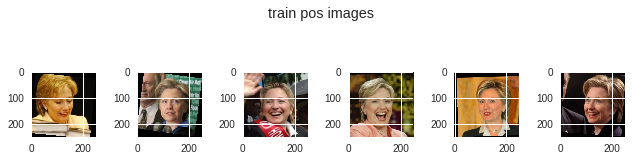

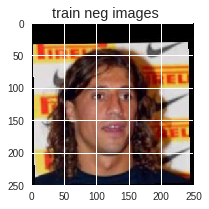

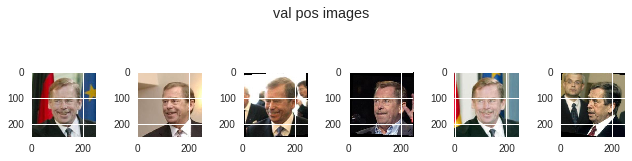

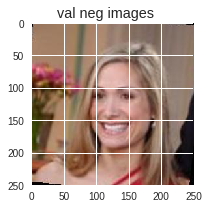

In [0]:
#setting datadir
data_dir="./lfw_data/"
#loading data
data=Data(data_dir)
data.load_and_split_data()

In [0]:
print (np.max(data.train_pos_imgs[0][0]))

254


***Make Data generators for training and validation***

In [0]:
num_people_per_batch=15
num_images_per_person=data.pos_thresh#+5
num_negs=30
num_batches_per_epoch=len(data.train_pos_imgs)//num_people_per_batch
num_batches_per_val_epoch=len(data.val_pos_imgs)//num_people_per_batch

num_epochs=500
embedding_size=128
margin=0.5

In [0]:
tr_gen,val_gen=data.get_batch_generators(num_people_per_batch,num_images_per_person,num_negs)

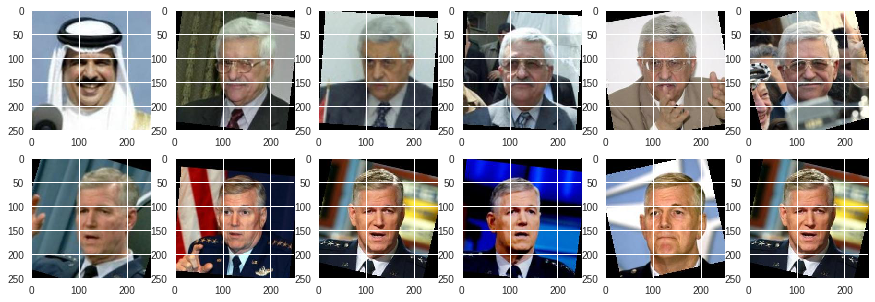

In [0]:
#checking
fig,axis=plt.subplots(2,num_images_per_person,figsize=(15,5))
i=0
for imgs,_ in tr_gen:
  if (i==num_batches_per_epoch):
    for p in np.arange(2):
      for p_i in np.arange(num_images_per_person):
        im_num=(p*num_images_per_person)+p_i
        axis[p,p_i].imshow(imgs[im_num])
    break
  i+=1
#   if (i>=2*num_batches_per_epoch):
#       break
        


# ***Model Construction starts now***

***Making classes for Backbones***

In [0]:
class Inception_Net:
    
  def __init__(self,Input_layer):
    self.dropout_prob=0.0
    
    self.model=self.form_model(Input_layer)
  def inception2(self,batch_norm):
    conv2red=KL.Conv2D(64, kernel_size=(1, 1),
                   activation='relu',kernel_regularizer=regularizers.l2(self.dropout_prob),
                activity_regularizer=regularizers.l1(0.01))(batch_norm)
    conv2=KL.Conv2D(192, kernel_size=(3, 3),
                   activation='relu',padding='same',kernel_regularizer=regularizers.l2(self.dropout_prob),
                activity_regularizer=regularizers.l1(0.01))(conv2red)
    return conv2

  def inception3a(self,Input):
    tower_zero = KL.Conv2D(64, (1,1), activation='relu', padding='same',kernel_regularizer=regularizers.l2(self.dropout_prob),
                activity_regularizer=regularizers.l1(0.01))(Input)
    tower_one = KL.MaxPooling2D((3,3), strides=(1,1), padding='same')(Input)
    tower_one = KL.Conv2D(32, (1,1), activation='relu', padding='same',kernel_regularizer=regularizers.l2(self.dropout_prob),
                activity_regularizer=regularizers.l1(0.01))(tower_one)

    tower_two = KL.Conv2D(96, (1,1), activation='relu', padding='same',kernel_regularizer=regularizers.l2(self.dropout_prob),
                activity_regularizer=regularizers.l1(0.01))(Input)
    tower_two = KL.Conv2D(128, (3,3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(self.dropout_prob),
                activity_regularizer=regularizers.l1(0.01))(tower_two)

    tower_three = KL.Conv2D(16, (1,1), activation='relu', padding='same',kernel_regularizer=regularizers.l2(self.dropout_prob),
                activity_regularizer=regularizers.l1(0.01))(Input)
    tower_three = KL.Conv2D(32, (5,5), activation='relu', padding='same',kernel_regularizer=regularizers.l2(self.dropout_prob),
                activity_regularizer=regularizers.l1(0.01))(tower_three)

    x = KL.concatenate([tower_zero, tower_one, tower_two, tower_three], axis=3)
    return x

  def inception3b(self,Input):
    tower_zero = KL.Conv2D(64, (1,1), activation='relu', padding='same',kernel_regularizer=regularizers.l2(self.dropout_prob),
                activity_regularizer=regularizers.l1(0.01))(Input)
    tower_one = KL.MaxPooling2D((3,3), strides=(1,1), padding='same')(Input)
    tower_one = KL.Conv2D(64, (1,1), activation='relu', padding='same',kernel_regularizer=regularizers.l2(self.dropout_prob),
                activity_regularizer=regularizers.l1(0.01))(tower_one)

    tower_two = KL.Conv2D(96, (1,1), activation='relu', padding='same',kernel_regularizer=regularizers.l2(self.dropout_prob),
                activity_regularizer=regularizers.l1(0.01))(Input)
    tower_two = KL.Conv2D(128, (3,3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(self.dropout_prob),
                activity_regularizer=regularizers.l1(0.01))(tower_two)

    tower_three = KL.Conv2D(32, (1,1), activation='relu', padding='same',kernel_regularizer=regularizers.l2(self.dropout_prob),
                activity_regularizer=regularizers.l1(0.01))(Input)
    tower_three = KL.Conv2D(64, (5,5), activation='relu', padding='same',kernel_regularizer=regularizers.l2(self.dropout_prob),
                activity_regularizer=regularizers.l1(0.01))(tower_three)
    x = KL.concatenate([tower_zero,tower_one, tower_two, tower_three], axis=3)
    return x

  def inception3c(self,Input):
    tower_one = KL.MaxPooling2D((3,3), strides=2, padding='same')(Input)

    tower_two = KL.Conv2D(128, (1,1), activation='relu', padding='same',kernel_regularizer=regularizers.l2(self.dropout_prob),
                activity_regularizer=regularizers.l1(0.01))(Input)
    tower_two = KL.Conv2D(256, (3,3),strides=2, activation='relu', padding='same',kernel_regularizer=regularizers.l2(self.dropout_prob),
                activity_regularizer=regularizers.l1(0.01))(tower_two)

    tower_three = KL.Conv2D(32, (1,1), activation='relu', padding='same',kernel_regularizer=regularizers.l2(self.dropout_prob),
                activity_regularizer=regularizers.l1(0.01))(Input)
    tower_three = KL.Conv2D(64, (5,5), strides=2, activation='relu', padding='same',kernel_regularizer=regularizers.l2(self.dropout_prob),
                activity_regularizer=regularizers.l1(0.01))(tower_three)
    x = KL.concatenate([tower_one, tower_two, tower_three], axis=3)
    return x

  def inception4a(self,Input):
    tower_zero = KL.Conv2D(256, (1,1), activation='relu', padding='same',kernel_regularizer=regularizers.l2(self.dropout_prob),
                activity_regularizer=regularizers.l1(0.01))(Input)
    tower_one = KL.MaxPooling2D((3,3), strides=(1,1), padding='same')(Input)
    tower_one = KL.Conv2D(128, (1,1), activation='relu', padding='same',kernel_regularizer=regularizers.l2(self.dropout_prob),
                activity_regularizer=regularizers.l1(0.01))(tower_one)

    tower_two = KL.Conv2D(96, (1,1), activation='relu', padding='same',kernel_regularizer=regularizers.l2(self.dropout_prob),
                activity_regularizer=regularizers.l1(0.01))(Input)
    tower_two = KL.Conv2D(192, (3,3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(self.dropout_prob),
                activity_regularizer=regularizers.l1(0.01))(tower_two)

    tower_three = KL.Conv2D(32, (1,1), activation='relu', padding='same',kernel_regularizer=regularizers.l2(self.dropout_prob),
                activity_regularizer=regularizers.l1(0.01))(Input)
    tower_three = KL.Conv2D(64, (5,5), activation='relu', padding='same',kernel_regularizer=regularizers.l2(self.dropout_prob),
                activity_regularizer=regularizers.l1(0.01))(tower_three)
    x = KL.concatenate([tower_zero,tower_one, tower_two, tower_three], axis=3)
    return x

  def inception4b(self,Input):
    tower_zero = KL.Conv2D(224, (1,1), activation='relu', padding='same')(Input)
    tower_one = KL.MaxPooling2D((3,3), strides=(1,1), padding='same')(Input)
    tower_one = KL.Conv2D(128, (1,1), activation='relu', padding='same')(tower_one)

    tower_two = KL.Conv2D(112, (1,1), activation='relu', padding='same')(Input)
    tower_two = KL.Conv2D(224, (3,3), activation='relu', padding='same')(tower_two)

    tower_three = KL.Conv2D(32, (1,1), activation='relu', padding='same')(Input)
    tower_three = KL.Conv2D(64, (5,5), activation='relu', padding='same')(tower_three)
    x = KL.concatenate([tower_zero,tower_one, tower_two, tower_three], axis=3)
    return x

  def inception4c(self,Input):
    tower_zero = KL.Conv2D(192, (1,1), activation='relu', padding='same')(Input)
    tower_one = KL.MaxPooling2D((3,3), strides=(1,1), padding='same')(Input)
    tower_one = KL.Conv2D(128, (1,1), activation='relu', padding='same')(tower_one)

    tower_two = KL.Conv2D(128, (1,1), activation='relu', padding='same')(Input)
    tower_two = KL.Conv2D(256, (3,3), activation='relu', padding='same')(tower_two)

    tower_three = KL.Conv2D(32, (1,1), activation='relu', padding='same')(Input)
    tower_three = KL.Conv2D(64, (5,5), activation='relu', padding='same')(tower_three)
    x = KL.concatenate([tower_zero,tower_one, tower_two, tower_three], axis=3)
    return x

  def inception4d(self,Input):
    tower_zero = KL.Conv2D(160, (1,1), activation='relu', padding='same')(Input)
    tower_one = KL.MaxPooling2D((3,3), strides=(1,1), padding='same')(Input)
    tower_one = KL.Conv2D(128, (1,1), activation='relu', padding='same')(tower_one)

    tower_two = KL.Conv2D(144, (1,1), activation='relu', padding='same')(Input)
    tower_two = KL.Conv2D(288, (3,3), activation='relu', padding='same')(tower_two)

    tower_three = KL.Conv2D(32, (1,1), activation='relu', padding='same')(Input)
    tower_three = KL.Conv2D(64, (5,5), activation='relu', padding='same')(tower_three)
    x = KL.concatenate([tower_zero,tower_one, tower_two, tower_three], axis=3)
    return x


  def inception4e(self,Input):
    tower_one = KL.MaxPooling2D((3,3), strides=2, padding='same')(Input)

    tower_two = KL.Conv2D(160, (1,1), activation='relu', padding='same')(Input)
    tower_two = KL.Conv2D(256, (3,3), strides=2, activation='relu', padding='same')(tower_two)

    tower_three = KL.Conv2D(64, (1,1), activation='relu', padding='same')(Input)
    tower_three = KL.Conv2D(128, (5,5), strides=2, activation='relu', padding='same')(tower_three)
    x = KL.concatenate([tower_one, tower_two, tower_three], axis=3)
    return x

  def inception5a(self,Input):
    tower_zero = KL.Conv2D(384, (1,1), activation='relu', padding='same')(Input)
    tower_one = KL.MaxPooling2D((3,3), strides=(1,1), padding='same')(Input)
    tower_one = KL.Conv2D(128, (1,1), activation='relu', padding='same')(tower_one)

    tower_two = KL.Conv2D(192, (1,1), activation='relu', padding='same')(Input)
    tower_two = KL.Conv2D(384, (3,3), activation='relu', padding='same')(tower_two)

    tower_three = KL.Conv2D(48, (1,1), activation='relu', padding='same')(Input)
    tower_three = KL.Conv2D(128, (5,5), activation='relu', padding='same')(tower_three)
    x = KL.concatenate([tower_zero,tower_one, tower_two, tower_three], axis=3)
    return x

  def inception5b(self,Input):
    tower_zero = KL.Conv2D(384, (1,1), activation='relu', padding='same')(Input)
    tower_one = KL.MaxPooling2D((3,3), strides=(1,1), padding='same')(Input)
    tower_one = KL.Conv2D(128, (1,1), activation='relu', padding='same')(tower_one)

    tower_two = KL.Conv2D(192, (1,1), activation='relu', padding='same')(Input)
    tower_two = KL.Conv2D(384, (3,3), activation='relu', padding='same')(tower_two)

    tower_three = KL.Conv2D(48, (1,1), activation='relu', padding='same')(Input)
    tower_three = KL.Conv2D(128, (5,5), activation='relu', padding='same')(tower_three)
    x = KL.concatenate([tower_zero,tower_one, tower_two, tower_three], axis=3)
    return x
  
  def form_model(self,Input_layer):
    conv1=KL.Conv2D(64, kernel_size=(7, 7),
                 activation='relu',strides=2,padding='same')(Input_layer)

    pool1=KL.MaxPooling2D(pool_size=(3, 3),strides=2,padding='same')(conv1)
    batch_norm=KL.BatchNormalization()(pool1)

    conv2=self.inception2(batch_norm)

    batch_norm2=KL.BatchNormalization()(conv2)
    pool2=KL.MaxPooling2D(pool_size=(3, 3),strides=2,padding='same')(batch_norm2)

    x  =self.inception3a(pool2)
    x1=self.inception3b(x)
    x2=self.inception3c(x1)
    x3=self.inception4a(x2)
    x4=self.inception4b(x3)
    x5=self.inception4c(x4)
    x6=self.inception4d(x5)
    x7=self.inception4e(x6)
    x8=self.inception5a(x7)
    x9=self.inception5b(x8)

    return x9

In [0]:
class MobileNetV2:
    def __init__(self,Input_layer):
        self.model=self.make_model(Input_layer)
    
    def expansion_layer(self,input_,expansion_factor):
        inp_channels=K.int_shape(input_)[-1]
        x=KL.Conv2D(inp_channels*expansion_factor,(1,1),strides=(1,1),padding='same') (input_)
        x=KL.BatchNormalization()(x)
        x=KL.Activation('relu')(x)
        return x
      
    def inverted_residual_block(self,input_,expansion_factor,output_channels,kernel,stride,flag):
        x=self.expansion_layer(input_,expansion_factor)
        x=KL.DepthwiseConv2D(kernel,stride,padding='same')(x)
        x=KL.BatchNormalization()(x)
        x=KL.Activation('relu')(x)
#         x=relu(x)
        x=KL.Conv2D(output_channels,(1,1),strides=(1,1),padding='same')(x)
        x=KL.BatchNormalization()(x)
        if (flag):
            x=KL.add([input_,x])
        return x
    def n_inverted_residual_blocks(self,input_,expansion_factor,output_channels,kernel,stride,n):
        x=self.inverted_residual_block(input_,expansion_factor,output_channels,kernel,stride,False)
        for i in range(n-1):
            x=self.inverted_residual_block(x,expansion_factor,output_channels,kernel,(1,1),True)
        return x
    def make_model(self,Input_layer):
        x=KL.Conv2D(32,kernel_size=(3,3),strides=(2,2),padding='same')(Input_layer)
        x=self.n_inverted_residual_blocks(x,1,16,(3,3),(1,1),1)
        x=self.n_inverted_residual_blocks(x,3,24,(3,3),(2,2),2)
        x=self.n_inverted_residual_blocks(x,3,32,(3,3),(2,2),3)
        x=self.n_inverted_residual_blocks(x,3,64,(3,3),(2,2),4)
        x=self.n_inverted_residual_blocks(x,3,96,(3,3),(1,1),3)
        x=self.n_inverted_residual_blocks(x,2,160,(3,3),(2,2),3)
        x=self.n_inverted_residual_blocks(x,2,320,(3,3),(1,1),1)
        avg_pool=KL.AveragePooling2D()(x)
        avg_pool=KL.Flatten()(avg_pool)
#         Dropout=KL.Dropout(0.3, noise_shape=None, seed=None)(avg_pool)
        x=KL.Dense(128)(avg_pool)
        
        return x
      

In [0]:
class custom_backbone:
    def __init__(self,Input_layer):
        self.model=self.make_model(Input_layer)
    
    
    def make_model(self,Input_layer):
        initializer='glorot_uniform'
        x=KL.Conv2D(64, kernel_size=(7, 7),
                 activation='relu',strides=2,padding='same',kernel_initializer=initializer)(Input_layer)
        x = KL.MaxPooling2D(pool_size=(3, 3),strides=2,padding='same')(x)
        x = KL.BatchNormalization()(x)

        x = KL.Conv2D(64, kernel_size=(1, 1),activation='relu',strides=1,
                      padding='same',kernel_initializer=initializer)(x)
        
        x = KL.Conv2D(192, kernel_size=(3, 3),activation='relu',strides=1,
                      padding='same',kernel_initializer=initializer)(x)
        
        x = KL.MaxPooling2D(pool_size=(3, 3),strides=2,padding='same')(x)

        x = KL.Conv2D(192, kernel_size=(1, 1),activation='relu',strides=1,
                      padding='same',kernel_initializer=initializer)(x)
        
        x = KL.Conv2D(384, kernel_size=(3, 3),activation='relu',strides=1,
                      padding='same',kernel_initializer=initializer)(x)
        
        x = KL.MaxPooling2D(pool_size=(3, 3),strides=2,padding='same')(x)

        x = KL.Conv2D(384, kernel_size=(1, 1),activation='relu',strides=1,
                      padding='same',kernel_initializer=initializer)(x)
        
        x = KL.Conv2D(256, kernel_size=(3, 3),activation='relu',strides=1,
                      padding='same',kernel_initializer=initializer)(x)
        
        x = KL.Conv2D(256, kernel_size=(1, 1),activation='relu',strides=1,
                      padding='same',kernel_initializer=initializer)(x)
        
        x = KL.Conv2D(256, kernel_size=(3, 3),activation='relu',strides=1,
                      padding='same',kernel_initializer=initializer)(x)
        
        x = KL.Conv2D(256, kernel_size=(1, 1),activation='relu',strides=1,
                      padding='same',kernel_initializer=initializer)(x)
        
        x = KL.Conv2D(256, kernel_size=(3, 3),activation='relu',strides=1,
                      padding='same',kernel_initializer=initializer)(x)
        
        x = KL.MaxPooling2D(pool_size=(3, 3),strides=2,padding='same')(x)

        x = KL.Flatten()(x)

        x = KL.MaxoutDense(3*128,2,name='densefc1')(x)

        x = KL.MaxoutDense(3*128,2,name='densefc2')(x)

        embeddings=KL.Dense(128)(x)
        return embeddings
      

# ***Forming Tiplet Loss ***

In [0]:
#func for l2 distance
def l2(x,y):
#     return np.sqrt(np.sum(np.power((x-y),2),axis=-1))
#     return K.sqrt(K.sum(K.square(x-y), axis=-1))
    return K.sum(K.square(x-y), axis=-1)


def triplet_loss_graph(batch_embeddings,num_persons,num_images_per_person,num_negs,embedding_size,margin,d_thresh,val_mask,loss_mask):
    #todo imput preprocessing,negative anchors
    #inputs
    #batch_embeddings (outputs from the model) shape=((num_persons*num_images_per_person)+num_negs),embedding size
    #num persons: num of unique identities for anchors in the batch
    #num_images_per_person: num of images fro each identity in the anchors
    #num_negs=number of negative images in the end of the batch
    #embedding size: usually 128
    #margin: margin used in loss
    
    #ouput
    #loss,VAL
    
    num_persons=tf.cast(num_persons,tf.int32)
    num_images_per_person=persons=tf.cast(num_images_per_person,tf.int32)
    num_negs=tf.cast(num_negs,tf.int32)
    embedding_size=tf.cast(embedding_size,tf.int32)
    
    
    #splitting anchors and negs
    num_anchors=num_persons*num_images_per_person
#     print (num_anchors)
    anchors,negs=tf.split(batch_embeddings,[num_anchors,num_negs])
    
    #numpersons*num_images_perperson,128
    #finding l2 distance all positive
    anchors1=tf.reshape(anchors,(num_persons,num_images_per_person,1,embedding_size))
    anchors2=tf.reshape(anchors,(num_persons,1,num_images_per_person,embedding_size))
    l2_all_pos=l2(anchors1,anchors2)
    
    #l2 all positive shape=num_persons,numimagesperperson,numimagesperperson
    
    inds=tf.where(val_mask>0)
    VAL=tf.gather_nd(l2_all_pos,inds)
    VAL=tf.reduce_mean(tf.cast((VAL<d_thresh),dtype=tf.float32))

    
    
    #negative distances
    l2_all_negs=l2(tf.reshape(anchors,(-1,1,embedding_size)),negs)
    FAR=tf.reduce_mean(tf.cast((l2_all_negs<d_thresh),dtype=tf.float32))

    #shape=num_anchors,num_neg
    
    #reshaping and tiling negative distances
    reshaped_l2_all_negs=tf.reshape(l2_all_negs,(num_persons,num_images_per_person,1,num_negs))
    tiled_l2_all_negs=tf.tile(reshaped_l2_all_negs,(1,1,num_images_per_person,1))
    #shape= num_persons,num_images_per_person,num_images_per_person,num_negs 
    
    #reshaping l2 all pos to num_persons*num_images_per_person*num_images_per_person,1
    l2_all_pos=tf.reshape(l2_all_pos,(-1,1))
    
    
    #reshaping l2 all neg to num_persons*num_images_per_person*num_images_per_person,num_negs
    l2_all_negs=tf.reshape(tiled_l2_all_negs,(-1,num_negs))
    
    #forming loss
    loss=l2_all_pos-l2_all_negs
#     loss=tf.Print(loss,[loss],"\nPrinting loss before mean",summarize=20)
    
    #gatheing indices where loss gt than 0 (semihard and hard negatives)
    
    loss=loss+margin
    loss=loss*loss_mask
#     inds=tf.where(loss>0)
#     loss=tf.gather_nd(loss,inds) 
    
    
    loss=tf.maximum(loss,0.0)
    
    loss = K.switch(tf.size(loss) > 0, K.mean(loss), tf.constant(0.0))
    VAL= K.switch(tf.size(loss) > 0,VAL, tf.constant(0.0))
    FAR= K.switch(tf.size(loss) > 0,FAR, tf.constant(1.0))
    
    return [loss,VAL,FAR]

    

    
    
    
    


***Class for Facenet Model***

In [0]:
class Facenet_Model:
  def __init__(self,input_shape,num_people_per_batch,num_images_per_person,num_negs,embedding_size,margin):
    self.input_shape=input_shape
    self.num_people_per_batch=num_people_per_batch
    self.num_images_per_person=num_images_per_person
    self.num_negs=num_negs
    self.embedding_size=embedding_size
    self.margin=margin
    self.use_hard_triplets=False
    self.d_threshold=0.5
    self.backbone="custom backbone"
    
    #learning rate params
    self.lr_drop_factor=0.3
    self.initial_lr=0.01
    self.epochs_drop=200
    
     
  def construct_model(self):
    self.Input_placeholder = Input(shape = self.input_shape)
    num_people_per_batch_t=K.constant(self.num_people_per_batch,dtype=tf.int32)
    num_images_per_person_t=K.constant(self.num_images_per_person,dtype=tf.int32)
    num_negs_t=K.constant(self.num_negs,dtype=tf.int32)
    embedding_size_t=K.constant(self.embedding_size,dtype=tf.int32)
    margin_t=K.constant(self.margin,dtype=tf.float32)
    
    d_thresh_t=K.constant(self.d_threshold,dtype=tf.float32)
    
    if self.backbone=="custom backbone":
      backbone_output=custom_backbone(self.Input_placeholder).model
    elif self.backbone=="mobile net":
      backbone_output=MobileNetV2(self.Input_placeholder).model
    self.embeddings_unnormalized=backbone_output
    self.embeddings=KL.Lambda(lambda x:K.l2_normalize(x,axis=1))(self.embeddings_unnormalized)

    loss_mask=np.ones((num_images_per_person,num_images_per_person))
    np.fill_diagonal(loss_mask,0)
    val_mask=loss_mask
    loss_mask=np.tile(np.expand_dims(loss_mask,-1),[1,1,num_negs])
    loss_mask=np.tile(np.expand_dims(loss_mask,0),[num_people_per_batch,1,1,1]).reshape(-1,num_negs)
    loss_mask_t=K.constant(loss_mask,dtype=tf.float32)
    val_mask=np.tile(np.expand_dims(val_mask,0),[num_people_per_batch,1,1])
    val_mask_t=K.constant(val_mask,dtype=tf.float32)
    
    [self.loss,self.VAL,self.FAR]=KL.Lambda(lambda x: triplet_loss_graph(*x), name="l2_loss")(
                    [self.embeddings,num_people_per_batch_t,num_images_per_person_t,num_negs_t,embedding_size_t,margin_t,d_thresh_t,val_mask_t,loss_mask_t])   


    
  def compile(self):
    self.model = Model(input=self.Input_placeholder,  outputs=[self.embeddings_unnormalized,self.embeddings])

    self.model.add_loss(self.loss)

    print (self.model.summary())
   
    self.model.compile(loss=None,
                     optimizer=keras.optimizers.Adam(lr=0),
                     )
    self.model.metrics_names.append("VAL")
    self.model.metrics_tensors.append(self.VAL)
    self.model.metrics_names.append("FAR")
    self.model.metrics_tensors.append(self.FAR)
    
    
  def lr_scheduler(self,epoch):
#     lrate=self.initial_lr*math.pow(self.lr_drop_factor,math.floor())
    temp=(float(epoch))/self.epochs_drop
    lrate = self.initial_lr * math.pow(self.lr_drop_factor, math.floor(temp))
    
    if temp==int(temp):
      print ("changing lr to {}".format(lrate))
#     print (lrate)
    return lrate
    
  def train(self,train_data_gen,train_steps_per_epoch, epochs,val_data_gen,val_steps):
    lrate = keras.callbacks.LearningRateScheduler(self.lr_scheduler,verbose=0)
    callbacks_list = [lrate]
    
    hist=self.model.fit_generator(train_data_gen,steps_per_epoch=train_steps_per_epoch, epochs=epochs,
                                  validation_data=val_data_gen,validation_steps=val_steps,callbacks=callbacks_list)
    return hist
  
  def save_weights(self,filename):
    self.model.save_weights(filename)
    
  def load_weights(self,filename):
    self.model.load_weights(filename)

In [0]:
#####stroing basic params of the model
input_shape=(250, 250, 3)
facenet_model=Facenet_Model(input_shape,num_people_per_batch,num_images_per_person,num_negs,embedding_size,margin)

In [0]:
#constructing and compiling model
facenet_model.construct_model()
facenet_model.compile()

/usr/local/lib/python3.6/dist-packages/keras/legacy/layers.py:74: UserWarning: The `MaxoutDense` layer is deprecated and will be removed after 06/2017.
  warnings.warn('The `MaxoutDense` layer is deprecated '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 250, 250, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      9472      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 63, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        4160      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 63, 192)       110784    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 192)       0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`


***Training***

In [0]:
#######training model
hist=facenet_model.train(tr_gen,num_batches_per_epoch,500,val_gen,num_batches_per_val_epoch)
facenet_model.save_weights("latest2.h5")

Epoch 1/500
changing lr to 0.01
16/16 [==============================] - 32s 2s/step - loss: 0.4082 - VAL: 0.9414 - FAR: 0.8652 - val_loss: 0.3747 - val_VAL: 0.8861 - val_FAR: 0.7317
Epoch 2/500
16/16 [==============================] - 19s 1s/step - loss: 0.3660 - VAL: 0.9005 - FAR: 0.7371 - val_loss: 0.3591 - val_VAL: 0.8903 - val_FAR: 0.7207
Epoch 3/500
16/16 [==============================] - 19s 1s/step - loss: 0.3492 - VAL: 0.8908 - FAR: 0.6823 - val_loss: 0.3730 - val_VAL: 0.8561 - val_FAR: 0.6806
Epoch 4/500
16/16 [==============================] - 19s 1s/step - loss: 0.3385 - VAL: 0.8608 - FAR: 0.6309 - val_loss: 0.3533 - val_VAL: 0.7655 - val_FAR: 0.5033
Epoch 5/500
16/16 [==============================] - 19s 1s/step - loss: 0.3441 - VAL: 0.8867 - FAR: 0.6794 - val_loss: 0.3543 - val_VAL: 0.8464 - val_FAR: 0.6199
Epoch 6/500
16/16 [==============================] - 19s 1s/step - loss: 0.3458 - VAL: 0.8830 - FAR: 0.6774 - val_loss: 0.3377 - val_VAL: 0.8497 - val_FAR: 0.6134
Ep

NameError: ignored

In [0]:
#######training model
hist=facenet_model.train(tr_gen,num_batches_per_epoch,200,val_gen,num_batches_per_val_epoch)
facenet_model.save_weights("latest.h5")

In [0]:
facenet_model.save_weights("latest2.h5")

***Visualizing metrics***

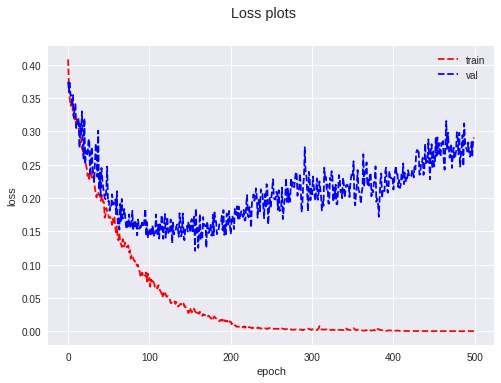

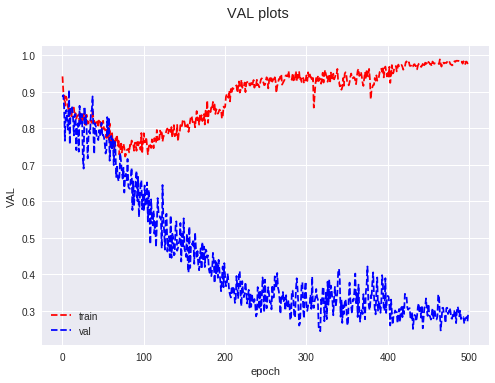

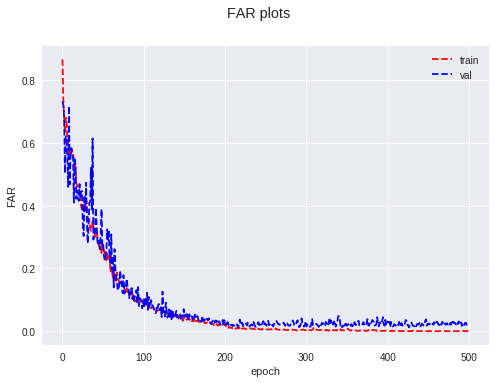

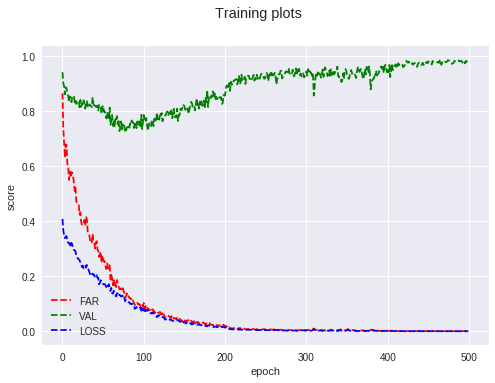

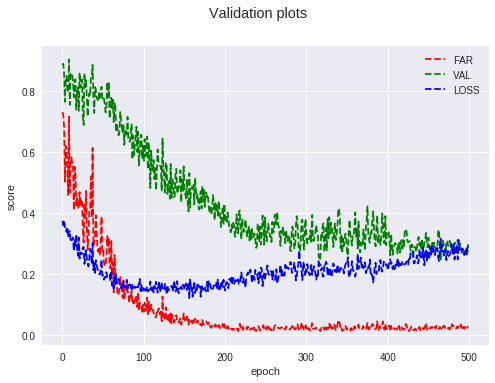

In [0]:
def visualize_results(history):
  val_loss=np.array(history.history['val_loss'])
  val_VAL=np.array(history.history['val_VAL'])
  val_FAR=np.array(history.history['val_FAR'])
  tr_loss=np.array(history.history['loss'])
  tr_VAL=np.array(history.history['VAL'])
  tr_FAR=np.array(history.history['FAR'])
  epochs=np.arange(len(tr_loss))
  
  fig,axis=plt.subplots(1,1)
  fig.suptitle("Loss plots")
#   fig.tight_layout()
  axis.plot(epochs,tr_loss,'r--',label="train",animated=True)
  axis.plot(epochs,val_loss,'b--',label="val",animated=True)
  axis.set_ylabel("loss")
  axis.set_xlabel("epoch")
  
  axis.legend(["train","val"])
  
  
  fig,axis=plt.subplots(1,1)
  fig.suptitle("VAL plots")
#   fig.tight_layout()
  axis.plot(epochs,tr_VAL,'r--',label="train",animated=True)
  axis.plot(epochs,val_VAL,'b--',label="val",animated=True)
  axis.set_ylabel("VAL")
  axis.set_xlabel("epoch")
  axis.legend(["train","val"])
  
  
  fig,axis=plt.subplots(1,1)
  fig.suptitle("FAR plots")
#   fig.tight_layout()
  axis.plot(epochs,tr_FAR,'r--',label="train",animated=True)
  axis.plot(epochs,val_FAR,'b--',label="val",animated=True)
  axis.set_ylabel("FAR")
  axis.set_xlabel("epoch")
  axis.legend(["train","val"])
  
  fig,axis=plt.subplots(1,1)
  fig.suptitle("Training plots")
#   fig.tight_layout()
  axis.plot(epochs,tr_FAR,'r--',label="FAR",animated=True)
  axis.plot(epochs,tr_VAL,'g--',label="VAL",animated=True)
  axis.plot(epochs,tr_loss,'b--',label="LOSS",animated=True)
  axis.set_ylabel("score")
  axis.set_xlabel("epoch")
  axis.legend(["FAR","VAL","LOSS"])
  
  fig,axis=plt.subplots(1,1)
  fig.suptitle("Validation plots")
#   fig.tight_layout()
  axis.plot(epochs,val_FAR,'r--',label="FAR",animated=True)
  axis.plot(epochs,val_VAL,'g--',label="VAL",animated=True)
  axis.plot(epochs,val_loss,'b--',label="LOSS",animated=True)
  axis.set_ylabel("score")
  axis.set_xlabel("epoch")
  axis.legend(["FAR","VAL","LOSS"])
  
  
visualize_results(hist)

# ***Finding Accuracies***

In [0]:
#utility func for finding l2 squared dist
def np_l2(x,y):
#     return np.sqrt(np.sum(np.power((x-y),2),axis=-1))
#     return K.sqrt(K.sum(K.square(x-y), axis=-1))
    return np.sqrt(np.sum((x-y)**2, axis=-1))

####this function seperates images into two lists and also outputs their labels
def get_embedding_sample_images(images,num_em_imgs_per_person,h,w):
  num_persons=len(imgs)
  sample_images=[]
  sample_labels=[]
  embedding_images=[]
  embedding_labels=[]
  
  for i in range(num_persons):
    em_ims=images[i][:num_em_imgs_per_person]
    em_labels=[i for _ in range(num_em_imgs_per_person)]
    s_img=images[i][num_em_imgs_per_person]
    s_label=i
    
    sample_images.append(s_img)
    sample_labels.append(s_label)
    embedding_images.extend(em_ims)
    embedding_labels.extend(em_labels)
    
  embedding_images=np.stack(embedding_images,axis=0).reshape(-1,h,w,3)  /255.0
  sample_images=np.stack(sample_images,axis=0).reshape(-1,h,w,3)  /255.0
  sample_labels=np.array(sample_labels)
  embedding_labels=np.array(embedding_labels)
  
  return embedding_images,embedding_labels,sample_images,sample_labels
  
  
  
import scipy.stats
def find_acc(images,n_ref_imgs_per_person,model,K):
  #inputs
#   images: a list of list of images (each enetry is a list of images for a person)
# n_ref_imgs_per_person: number of images of a person to store (these images are then used to find predictions)

  embedding_images,embedding_labels,sample_images,sample_labels=  get_embedding_sample_images(data.train_pos_imgs,n_ref_imgs_per_person,250,250)
  
  [embeddings,_]=model.predict(embedding_images)
  [sample_embeddings,_]=model.predict(sample_images)
  predicted_labels=[]
  
  for i in range(len(sample_embeddings)):
    se=sample_embeddings[i]
    dists=np_l2(se,embeddings)
    idx = np.argpartition(np.squeeze(dists), K)
    topk_idx=idx[:K]
    topk_labels=np.atleast_1d(embedding_labels[topk_idx])
    majority_label=scipy.stats.mode(topk_labels)[0][0]
    person_label=majority_label
    
    predicted_labels.append(person_label)
    
   
  predicted_labels=np.array(predicted_labels)
  p_mask=predicted_labels==sample_labels
  print ("correctly classified {}".format(np.sum(p_mask)))
  acc=np.mean(p_mask)  
  print ("accuracy= {}".format(acc))  
  

In [0]:
#training accuracy
find_acc(data.train_pos_imgs,5,facenet_model.model,1)


correctly classified 89
accuracy= 0.7416666666666667


In [0]:
#validation accuracy
find_acc(data.val_pos_imgs,5,facenet_model.model,3)


correctly classified 88
accuracy= 0.7333333333333333


In [0]:
#test accuracy
test_names,test_images=data.load_test_data()
find_acc(test_images,3,facenet_model.model,1)

correctly classified 76
accuracy= 0.6333333333333333


***Prediction***

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
facenet_model.load_weights("/content/gdrive/My Drive/abcnew_new001v5.h5")
!unzip /content/gdrive/'My Drive'/facenet_image_db.zip
!unzip /content/gdrive/'My Drive'/facenet_test_images.zip


# # wei=open("abc_V1.h5",'')
# # ws=wei.read()
# # drive.mount('/content/gdrive')
# # with open('/content/gdrive/My Drive/weights_facenet_V1.h5','w') as f:
# #   f.write(ws)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Archive:  /content/gdrive/My Drive/facenet_image_db.zip
   creating: image_db/
   creating: image_db/keanu_reeves/
  inflating: image_db/keanu_reeves/1.jpg  
  inflating: image_db/keanu_reeves/2.jpeg  
  inflating: image_db/keanu_reeves/3.jpeg  
   creating: image_db/paul_walker/
  inflating: image_db/paul_walker/3.jpg  
  inflating: image_db/paul_walker/1.jpg  
  inflating: image_db/paul_walker/2.jpg  
   creating: image_db/jennifer_anniston/
  inflating: im

In [0]:
#load db and test images
from skimage.transform import resize as sk_resize

test_dir="./test_images"
image_db_dir="./image_db"
images_db_list=[]
names_db_list=[]
test_images=[]
for person_name in os.listdir(image_db_dir):
    folder_path=os.path.join(image_db_dir,person_name)

    for image in os.listdir(folder_path):
        image_path=os.path.join(folder_path,image)
        processed_im=sk_resize(io.imread(image_path),(250,250))
        images_db_list.append(processed_im)
        names_db_list.append(person_name)
        
for image in os.listdir(test_dir):
    image_path=os.path.join(test_dir,image)
    processed_im=sk_resize(io.imread(image_path),(250,250))
    test_images.append(processed_im)
  
test_images=np.stack(test_images,axis=0).reshape(-1,250,250,3)
images_db_list=np.stack(images_db_list,axis=0).reshape(-1,250,250,3)
names_db_list=np.array(names_db_list)



/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
def predict_names(db_images,db_names,test_images,model,K):
  

  
  [embeddings,_]=model.predict(db_images)
  [sample_embeddings,_]=model.predict(test_images)
  predicted_labels=[]
  
  for i in range(len(sample_embeddings)):
    se=sample_embeddings[i]
    dists=np_l2(se,embeddings)
    idx = np.argpartition(np.squeeze(dists), K)
    topk_idx=idx[:K]
    topk_labels=np.atleast_1d(db_names[topk_idx])
    majority_label=scipy.stats.mode(topk_labels)[0][0]
    person_label=majority_label
    
    predicted_labels.append(person_label)
    
   
  predicted_labels=np.array(predicted_labels)
  return predicted_labels


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


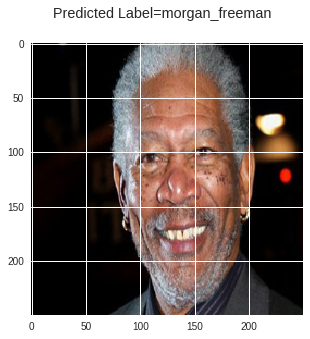

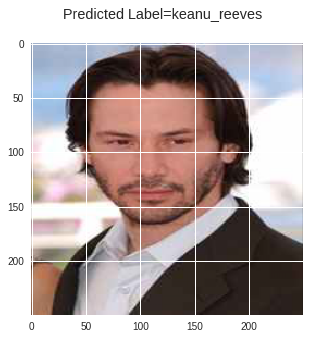

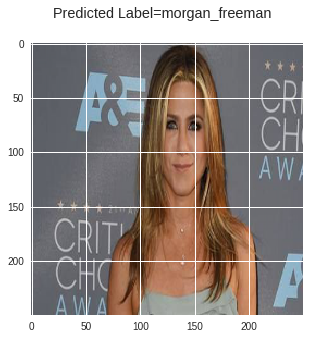

In [0]:
prediction_labels=predict_names(images_db_list,names_db_list,test_images,facenet_model.model,1)
print("\n\n")
for i in range(len(prediction_labels)):
  fig,axis=plt.subplots(1,figsize=(5,5))
  axis.imshow(test_images[i])
  fig.suptitle("Predicted Label={}".format(prediction_labels[i]))
# print (predictions)


# ***Miscellaneous***

In [0]:
Input_placeholder = Input(shape = (250, 250, 3))
num_people_per_batch_t=K.constant(num_people_per_batch,dtype=tf.int32)
num_images_per_person_t=K.constant(num_images_per_person,dtype=tf.int32)
num_negs_t=K.constant(num_negs,dtype=tf.int32)
embedding_size_t=K.constant(embedding_size,dtype=tf.int32)
margin_t=K.constant(margin,dtype=tf.float32)


# backbone_output=Inception_Net(Input_placeholder).model
# backbone_output=MobileNetV2(Input_placeholder).model
# avg_pool=KL.AveragePooling2D()(backbone_output)
# avg_pool=KL.Flatten()(avg_pool)
# Dropout=KL.Dropout(0.3, noise_shape=None, seed=None)(avg_pool)
# embeddings=KL.Dense(128)(avg_pool)
# embeddings=KL.BatchNormalization()(embeddings)

backbone_output=custom_backbone(Input_placeholder).model
embeddings_unnormalized=backbone_output
embeddings=KL.Lambda(lambda x:K.l2_normalize(x,axis=1))(embeddings_unnormalized)

loss_mask=np.ones((num_images_per_person,num_images_per_person))
np.fill_diagonal(loss_mask,0)
val_mask=loss_mask
loss_mask=np.tile(np.expand_dims(loss_mask,-1),[1,1,num_negs])
loss_mask=np.tile(np.expand_dims(loss_mask,0),[num_people_per_batch,1,1,1]).reshape(-1,num_negs)
loss_mask_t=K.constant(loss_mask,dtype=tf.float32)
val_mask=np.tile(np.expand_dims(val_mask,0),[num_people_per_batch,1,1])
val_mask_t=K.constant(val_mask,dtype=tf.float32)
[loss,VAL,FAR]=KL.Lambda(lambda x: triplet_loss_graph(*x), name="l2_loss")(
                [embeddings,num_people_per_batch_t,num_images_per_person_t,num_negs_t,embedding_size_t,margin_t,val_mask_t,loss_mask_t])   






/usr/local/lib/python3.6/dist-packages/keras/legacy/layers.py:74: UserWarning: The `MaxoutDense` layer is deprecated and will be removed after 06/2017.
  warnings.warn('The `MaxoutDense` layer is deprecated '


In [0]:
model = Model(input=Input_placeholder,  outputs=[embeddings_unnormalized,embeddings])
print (loss.shape)
model.add_loss(loss)

print (model.summary())
# model.compile(loss=None,
#                  optimizer=keras.optimizers.Adam(lr=0.0001),
#                  )
model.compile(loss=None,
                 optimizer=keras.optimizers.Adam(lr=0.01),
                 )
model.metrics_names.append("VAL")
model.metrics_tensors.append(VAL)
model.metrics_names.append("FAR")
model.metrics_tensors.append(FAR)

()
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 250, 250, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      9472      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 63, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        4160      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 63, 192)       110784    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 192)       0         
_______

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


In [0]:
hist=model.fit_generator(tr_gen,steps_per_epoch=num_batches_per_epoch, epochs=5,validation_data=val_gen,validation_steps=num_batches_per_val_epoch)


Epoch 1/5
13/13 [==============================] - 15s 1s/step - loss: 0.3814 - VAL: 0.7577 - FAR: 0.6552 - val_loss: 0.3953 - val_VAL: 0.9367 - val_FAR: 0.8075
Epoch 2/5
13/13 [==============================] - 11s 859ms/step - loss: 0.3476 - VAL: 0.6600 - FAR: 0.4340 - val_loss: 0.3549 - val_VAL: 0.6300 - val_FAR: 0.3889
Epoch 3/5
13/13 [==============================] - 11s 858ms/step - loss: 0.3325 - VAL: 0.6079 - FAR: 0.3733 - val_loss: 0.3060 - val_VAL: 0.6600 - val_FAR: 0.3942
Epoch 4/5
13/13 [==============================] - 11s 863ms/step - loss: 0.3271 - VAL: 0.6049 - FAR: 0.3802 - val_loss: 0.3382 - val_VAL: 0.7600 - val_FAR: 0.4939
Epoch 5/5
13/13 [==============================] - 11s 855ms/step - loss: 0.3169 - VAL: 0.6221 - FAR: 0.3524 - val_loss: 0.3447 - val_VAL: 0.5233 - val_FAR: 0.2700


In [0]:
print (hist.history)

{'val_loss': [0.3952595889568329, 0.35488513112068176, 0.3059908151626587, 0.33824124932289124, 0.34465494751930237], 'val_VAL': [0.9366666674613953, 0.6299999952316284, 0.6600000262260437, 0.7599999904632568, 0.5233333110809326], 'val_FAR': [0.8075000047683716, 0.3888888955116272, 0.3941666781902313, 0.49388888478279114, 0.27000001072883606], 'loss': [0.38136385495846087, 0.3476386620448186, 0.332545484487827, 0.3271135068856753, 0.3169298962904857], 'VAL': [0.7576923049413241, 0.6600000010086939, 0.6079487067002517, 0.6048718003126291, 0.6220512848633987], 'FAR': [0.6551923109934881, 0.43399572601685155, 0.3733333349227905, 0.38019230503302354, 0.35235042984669024]}


In [0]:
# model.fit_generator(tr_gen,steps_per_epoch=num_batches_per_epoch, epochs=num_epochs,validation_data=val_gen,validation_steps=num_batches_per_val_epoch)
model.fit_generator(tr_gen,steps_per_epoch=num_batches_per_epoch, epochs=100,validation_data=val_gen,validation_steps=num_batches_per_val_epoch)



Epoch 1/100
13/13 [==============================] - 25s 2s/step - loss: 0.3954 - VAL: 0.6918 - FAR: 0.5927 - val_loss: 0.3774 - val_VAL: 0.6333 - val_FAR: 0.4806
Epoch 2/100
13/13 [==============================] - 11s 881ms/step - loss: 0.3745 - VAL: 0.5782 - FAR: 0.4135 - val_loss: 0.4208 - val_VAL: 0.6700 - val_FAR: 0.6239
Epoch 3/100
13/13 [==============================] - 11s 879ms/step - loss: 0.3614 - VAL: 0.6582 - FAR: 0.4676 - val_loss: 0.3663 - val_VAL: 0.7400 - val_FAR: 0.5408
Epoch 4/100
13/13 [==============================] - 11s 878ms/step - loss: 0.3467 - VAL: 0.6328 - FAR: 0.4062 - val_loss: 0.3305 - val_VAL: 0.6833 - val_FAR: 0.4197
Epoch 5/100
13/13 [==============================] - 11s 877ms/step - loss: 0.3179 - VAL: 0.6272 - FAR: 0.3663 - val_loss: 0.3388 - val_VAL: 0.6367 - val_FAR: 0.4094
Epoch 6/100
13/13 [==============================] - 11s 878ms/step - loss: 0.3413 - VAL: 0.6410 - FAR: 0.3971 - val_loss: 0.3329 - val_VAL: 0.5833 - val_FAR: 0.3383
Epoch 7

In [0]:
print (num_batches_per_val_epoch)

1


In [0]:
K.set_value(model.optimizer.lr, 0.001)
model.fit_generator(tr_gen,steps_per_epoch=num_batches_per_epoch, epochs=100,validation_data=val_gen,validation_steps=num_batches_per_val_epoch)


Epoch 1/100
13/13 [==============================] - 14s 1s/step - loss: 0.1010 - VAL: 0.3079 - FAR: 0.0210 - val_loss: 0.2099 - val_VAL: 0.2533 - val_FAR: 0.0161
Epoch 2/100
13/13 [==============================] - 11s 862ms/step - loss: 0.0926 - VAL: 0.3200 - FAR: 0.0235 - val_loss: 0.1762 - val_VAL: 0.2133 - val_FAR: 0.0161
Epoch 3/100
13/13 [==============================] - 11s 867ms/step - loss: 0.0836 - VAL: 0.3005 - FAR: 0.0190 - val_loss: 0.2070 - val_VAL: 0.2200 - val_FAR: 0.0150
Epoch 4/100
13/13 [==============================] - 11s 859ms/step - loss: 0.0950 - VAL: 0.3136 - FAR: 0.0221 - val_loss: 0.1742 - val_VAL: 0.2300 - val_FAR: 0.0128
Epoch 5/100
13/13 [==============================] - 11s 872ms/step - loss: 0.0805 - VAL: 0.3056 - FAR: 0.0214 - val_loss: 0.1890 - val_VAL: 0.2200 - val_FAR: 0.0172
Epoch 6/100
13/13 [==============================] - 11s 863ms/step - loss: 0.0719 - VAL: 0.3321 - FAR: 0.0196 - val_loss: 0.2188 - val_VAL: 0.1767 - val_FAR: 0.0161
Epoch 7

In [0]:
model.fit_generator(tr_gen,steps_per_epoch=num_batches_per_epoch, epochs=200,validation_data=val_gen,validation_steps=num_batches_per_val_epoch)


Epoch 1/200
13/13 [==============================] - 15s 1s/step - loss: 0.0497 - VAL: 0.2992 - FAR: 0.0094 - val_loss: 0.2045 - val_VAL: 0.1667 - val_FAR: 0.0111
Epoch 2/200
13/13 [==============================] - 11s 869ms/step - loss: 0.0429 - VAL: 0.3090 - FAR: 0.0093 - val_loss: 0.2570 - val_VAL: 0.1833 - val_FAR: 0.0067
Epoch 3/200
13/13 [==============================] - 11s 864ms/step - loss: 0.0432 - VAL: 0.3141 - FAR: 0.0096 - val_loss: 0.1792 - val_VAL: 0.1800 - val_FAR: 0.0067
Epoch 4/200
13/13 [==============================] - 11s 863ms/step - loss: 0.0467 - VAL: 0.3192 - FAR: 0.0102 - val_loss: 0.2599 - val_VAL: 0.1567 - val_FAR: 0.0075
Epoch 5/200
13/13 [==============================] - 11s 874ms/step - loss: 0.0418 - VAL: 0.3064 - FAR: 0.0091 - val_loss: 0.2620 - val_VAL: 0.1167 - val_FAR: 0.0086
Epoch 6/200
13/13 [==============================] - 11s 867ms/step - loss: 0.0436 - VAL: 0.2985 - FAR: 0.0103 - val_loss: 0.1686 - val_VAL: 0.1700 - val_FAR: 0.0061
Epoch 7

In [0]:
model.fit_generator(tr_gen,steps_per_epoch=num_batches_per_epoch, epochs=100,validation_data=val_gen,validation_steps=num_batches_per_val_epoch)


Epoch 1/100
13/13 [==============================] - 14s 1s/step - loss: 0.0131 - VAL: 0.2508 - FAR: 0.0012 - val_loss: 0.2969 - val_VAL: 0.1000 - val_FAR: 5.5556e-04
Epoch 2/100
13/13 [==============================] - 11s 866ms/step - loss: 0.0120 - VAL: 0.2533 - FAR: 3.4188e-04 - val_loss: 0.2497 - val_VAL: 0.1033 - val_FAR: 5.5556e-04
Epoch 3/100
13/13 [==============================] - 11s 875ms/step - loss: 0.0125 - VAL: 0.2474 - FAR: 9.8291e-04 - val_loss: 0.2255 - val_VAL: 0.0967 - val_FAR: 0.0000e+00
Epoch 4/100
13/13 [==============================] - 11s 865ms/step - loss: 0.0129 - VAL: 0.2544 - FAR: 6.1966e-04 - val_loss: 0.2203 - val_VAL: 0.0900 - val_FAR: 0.0000e+00
Epoch 5/100
13/13 [==============================] - 11s 871ms/step - loss: 0.0112 - VAL: 0.2444 - FAR: 3.6325e-04 - val_loss: 0.2420 - val_VAL: 0.0900 - val_FAR: 5.5556e-04
Epoch 6/100
13/13 [==============================] - 11s 863ms/step - loss: 0.0130 - VAL: 0.2441 - FAR: 5.7692e-04 - val_loss: 0.2136 - v

In [0]:
model.fit_generator(tr_gen,steps_per_epoch=num_batches_per_epoch, epochs=100,validation_data=val_gen,validation_steps=num_batches_per_val_epoch)

Epoch 1/100
13/13 [==============================] - 14s 1s/step - loss: 0.0074 - VAL: 0.2856 - FAR: 2.3504e-04 - val_loss: 0.2685 - val_VAL: 0.1067 - val_FAR: 0.0000e+00
Epoch 2/100
13/13 [==============================] - 11s 875ms/step - loss: 0.0068 - VAL: 0.2718 - FAR: 1.9231e-04 - val_loss: 0.2908 - val_VAL: 0.0933 - val_FAR: 5.5556e-04
Epoch 3/100
13/13 [==============================] - 11s 875ms/step - loss: 0.0067 - VAL: 0.2977 - FAR: 5.1282e-04 - val_loss: 0.2467 - val_VAL: 0.0867 - val_FAR: 0.0000e+00
Epoch 4/100
13/13 [==============================] - 11s 862ms/step - loss: 0.0051 - VAL: 0.2774 - FAR: 1.2821e-04 - val_loss: 0.2542 - val_VAL: 0.1467 - val_FAR: 5.5556e-04
Epoch 5/100
13/13 [==============================] - 11s 860ms/step - loss: 0.0076 - VAL: 0.2526 - FAR: 3.2051e-04 - val_loss: 0.1915 - val_VAL: 0.1000 - val_FAR: 0.0000e+00
Epoch 6/100
13/13 [==============================] - 11s 861ms/step - loss: 0.0067 - VAL: 0.2813 - FAR: 2.5641e-04 - val_loss: 0.2185

In [0]:
K.set_value(model.optimizer.lr, 0.0003)
model.fit_generator(tr_gen,steps_per_epoch=num_batches_per_epoch, epochs=100,validation_data=val_gen,validation_steps=num_batches_per_val_epoch)


Epoch 1/100
13/13 [==============================] - 15s 1s/step - loss: 0.0030 - VAL: 0.3141 - FAR: 2.1368e-05 - val_loss: 0.2989 - val_VAL: 0.0867 - val_FAR: 0.0000e+00
Epoch 2/100
13/13 [==============================] - 11s 869ms/step - loss: 0.0027 - VAL: 0.3190 - FAR: 1.4957e-04 - val_loss: 0.2345 - val_VAL: 0.1100 - val_FAR: 2.7778e-04
Epoch 3/100
13/13 [==============================] - 11s 856ms/step - loss: 0.0033 - VAL: 0.3031 - FAR: 2.1368e-04 - val_loss: 0.2822 - val_VAL: 0.1367 - val_FAR: 0.0000e+00
Epoch 4/100
13/13 [==============================] - 11s 861ms/step - loss: 0.0028 - VAL: 0.3231 - FAR: 2.9915e-04 - val_loss: 0.2901 - val_VAL: 0.0967 - val_FAR: 0.0000e+00
Epoch 5/100
13/13 [==============================] - 11s 858ms/step - loss: 0.0032 - VAL: 0.3051 - FAR: 2.1368e-05 - val_loss: 0.2541 - val_VAL: 0.1200 - val_FAR: 0.0000e+00
Epoch 6/100
13/13 [==============================] - 11s 866ms/step - loss: 0.0028 - VAL: 0.2759 - FAR: 2.1368e-05 - val_loss: 0.2805

In [0]:
K.set_value(model.optimizer.lr, 0.0001)
model.fit_generator(tr_gen,steps_per_epoch=num_batches_per_epoch, epochs=100,validation_data=val_gen,validation_steps=num_batches_per_val_epoch)


Epoch 1/100
13/13 [==============================] - 14s 1s/step - loss: 0.0020 - VAL: 0.3367 - FAR: 1.4957e-04 - val_loss: 0.3108 - val_VAL: 0.0800 - val_FAR: 0.0000e+00
Epoch 2/100
13/13 [==============================] - 11s 860ms/step - loss: 0.0018 - VAL: 0.2997 - FAR: 2.1368e-05 - val_loss: 0.3150 - val_VAL: 0.1167 - val_FAR: 0.0000e+00
Epoch 3/100
13/13 [==============================] - 11s 866ms/step - loss: 0.0016 - VAL: 0.3210 - FAR: 8.5470e-05 - val_loss: 0.2858 - val_VAL: 0.0733 - val_FAR: 0.0000e+00
Epoch 4/100
13/13 [==============================] - 11s 865ms/step - loss: 0.0015 - VAL: 0.3303 - FAR: 0.0000e+00 - val_loss: 0.3053 - val_VAL: 0.1033 - val_FAR: 2.7778e-04
Epoch 5/100
13/13 [==============================] - 11s 858ms/step - loss: 0.0017 - VAL: 0.3190 - FAR: 6.4103e-05 - val_loss: 0.3208 - val_VAL: 0.1033 - val_FAR: 2.7778e-04
Epoch 6/100
13/13 [==============================] - 11s 857ms/step - loss: 0.0021 - VAL: 0.3228 - FAR: 6.4103e-05 - val_loss: 0.3080

In [0]:
model.save_weights("abcnew_new001v6.h5")

In [0]:
#utility func for finding l2 squared dist
def np_l2(x,y):
#     return np.sqrt(np.sum(np.power((x-y),2),axis=-1))
#     return K.sqrt(K.sum(K.square(x-y), axis=-1))
    return np.sqrt(np.sum((x-y)**2, axis=-1))

####this function seperates images into two lists and also outputs their labels
def get_embedding_sample_images(images,num_em_imgs_per_person,h,w):
  num_persons=len(imgs)
  sample_images=[]
  sample_labels=[]
  embedding_images=[]
  embedding_labels=[]
  
  for i in range(num_persons):
    em_ims=images[i][:num_em_imgs_per_person]
    em_labels=[i for _ in range(num_em_imgs_per_person)]
    s_img=images[i][num_em_imgs_per_person]
    s_label=i
    
    sample_images.append(s_img)
    sample_labels.append(s_label)
    embedding_images.extend(em_ims)
    embedding_labels.extend(em_labels)
    
  embedding_images=np.stack(embedding_images,axis=0).reshape(-1,h,w,3)  /255.0
  sample_images=np.stack(sample_images,axis=0).reshape(-1,h,w,3)  /255.0
  sample_labels=np.array(sample_labels)
  embedding_labels=np.array(embedding_labels)
  
  return embedding_images,embedding_labels,sample_images,sample_labels
  
  
  
import scipy.stats
def find_acc(images,n_ref_imgs_per_person,model,K):
  #inputs
#   images: a list of list of images (each enetry is a list of images for a person)
# n_ref_imgs_per_person: number of images of a person to store (these images are then used to find predictions)

  embedding_images,embedding_labels,sample_images,sample_labels=  get_embedding_sample_images(data.train_pos_imgs,n_ref_imgs_per_person,250,250)
  
  [embeddings,_]=model.predict(embedding_images)
  [sample_embeddings,_]=model.predict(sample_images)
  predicted_labels=[]
  
  for i in range(len(sample_embeddings)):
    se=sample_embeddings[i]
    dists=np_l2(se,embeddings)
    idx = np.argpartition(np.squeeze(dists), K)
    topk_idx=idx[:K]
    topk_labels=np.atleast_1d(embedding_labels[topk_idx])
    majority_label=scipy.stats.mode(topk_labels)[0][0]
    person_label=majority_label
    
    predicted_labels.append(person_label)
    
   
  predicted_labels=np.array(predicted_labels)
  p_mask=predicted_labels==sample_labels
  print ("correctly classified {}".format(np.sum(p_mask)))
  acc=np.mean(p_mask)  
  print ("accuracy= {}".format(acc))  
  


In [0]:
find_acc(data.train_pos_imgs,5,model,1)
find_acc(data.val_pos_imgs,3,model,1)
test_names,test_images=data.load_test_data()
find_acc(test_images,3,model,1)

correctly classified 119
accuracy= 0.7933333333333333


In [0]:
find_acc(data.val_pos_imgs,3,model,1)

correctly classified 115
accuracy= 0.7666666666666667


In [0]:
test_names,test_images=data.load_test_data()
find_acc(test_images,3,model,1)

correctly classified 115
accuracy= 0.7666666666666667


In [0]:
# model.fit_generator(data_gen,steps_per_epoch=num_batces_per_epoch, epochs=num_epochs)
# # # model.fit_generator(data_gen,steps_per_epoch=5, epochs=3)

In [0]:
# # model.fit_generator(data_gen,steps_per_epoch=num_batces_per_epoch, epochs=num_epochs)
# model.fit_generator(data_gen,steps_per_epoch=num_batces_per_epoch, epochs=num_epochs)


In [0]:
# model.save_weights("abc_V3.h5")

In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# model.save_weights("/content/gdrive/My Drive/weights_facenet_V3.h5")
# # wei=open("abc_V1.h5",'')
# # ws=wei.read()
# # drive.mount('/content/gdrive')
# # with open('/content/gdrive/My Drive/weights_facenet_V1.h5','w') as f:
# #   f.write(ws)

In [0]:
corr = 0
posTestImgs=data.val_pos_imgs
negImgs=data.train_neg_imgs#[p_imgs[0] for p_imgs in data.train_neg_imgs]

for i in range(len(posTestImgs)):
  randInd1 = np.random.randint(0, len(posTestImgs[i])-1)
  randInd2 = np.random.randint(0, len(posTestImgs[i])-1)
  randInd3 = np.random.randint(0, len(negImgs)-1)
#   print ("blah")
#   print (randInd3)
#   print ()
  randInd4 = np.random.randint(0, len(negImgs[randInd3]))
  anchor = posTestImgs[i][randInd1]
  positive = posTestImgs[i][randInd2]
  negative = negImgs[randInd3][randInd4]
  
  testData = np.stack([anchor, positive, negative])/255.0
  [predictions,_] = facenet_model.model.predict(testData)

  posDist = np.sum(np.square(np.subtract(predictions[0], predictions[1])))

  negDist = np.sum(np.square(np.subtract(predictions[0], predictions[2])))
  
  if (posDist<negDist):
    corr+=1
print (corr/(float(len(posTestImgs))))

0.967741935483871
